## Day 3 making making more part 3

In [109]:
# libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
words = open('/kaggle/input/nn-zere-hero/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [111]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)
vocab_size = len(itos)
print('vocabulary size : ', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocabulary size :  27


In [112]:
block_size = 3 # context length : how many characters do we take to predict the next one?
def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in  context), "---> ", itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xval, Yval = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10 %

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [113]:
# MLP 
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g) # uniform distribution
W1 = torch.randn((n_embd* block_size, n_hidden), generator = g ) * ( 5/3)/ ((n_embd* block_size) ** 0.5)# * 0.2 # kining_normal 
b1 = torch.randn(n_hidden, generator = g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1 ,b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # sum of paramerters in network
for p in parameters:
    p.requires_grad = True
    


12297


In [114]:
(torch.randn(10000) * 0.2).std()

tensor(0.2011)

tensor(0.0088) tensor(1.0065)
tensor(-0.0024) tensor(0.9977)


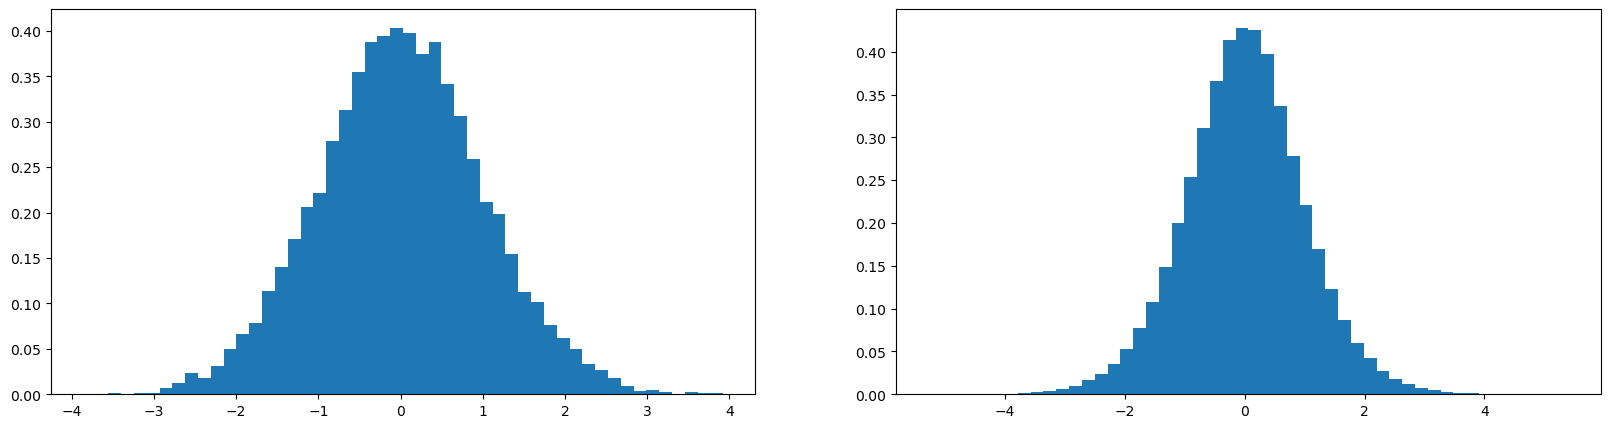

In [115]:
x = torch.randn(1000,10)
w = torch.randn(10, 200) / 10**0.5  # divide by fan_in
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);


In [116]:
hpreact.mean(0, keepdims = True).shape

torch.Size([1, 200])

In [117]:
hpreact.std(0, keepdims = True).shape

torch.Size([1, 200])

In [118]:
# train the network 
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)
   
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update the parameters
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
        
    # break

      0 /  200000: 3.2965
  10000 /  200000: 2.4525
  20000 /  200000: 2.0583
  30000 /  200000: 2.0571
  40000 /  200000: 2.0676
  50000 /  200000: 2.7455
  60000 /  200000: 2.0092
  70000 /  200000: 2.1926
  80000 /  200000: 1.9992
  90000 /  200000: 2.0933
 100000 /  200000: 2.3355
 110000 /  200000: 2.5076
 120000 /  200000: 2.0746
 130000 /  200000: 2.0605
 140000 /  200000: 2.1618
 150000 /  200000: 1.9167
 160000 /  200000: 2.3711
 170000 /  200000: 2.1525
 180000 /  200000: 1.8113
 190000 /  200000: 2.4366


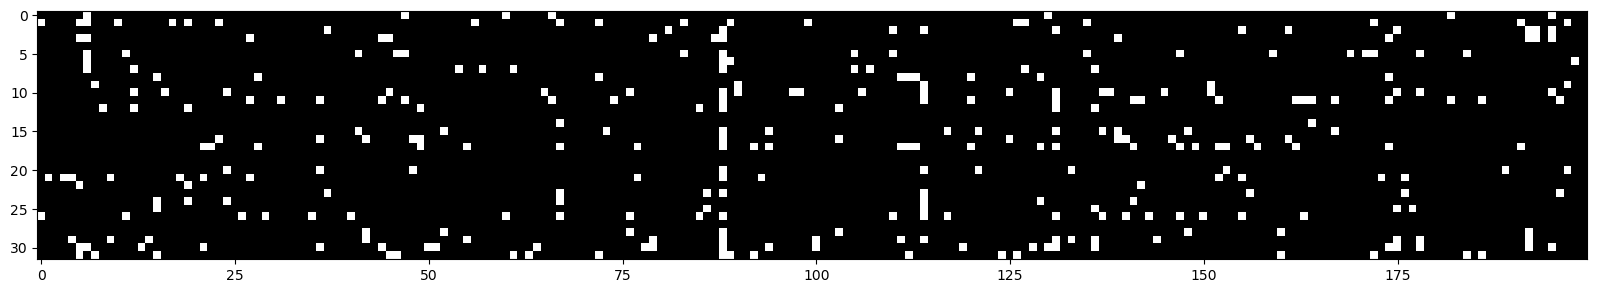

In [119]:
# visualizing the neuron that are very hard to train
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99 , cmap = 'gray', interpolation = 'nearest')

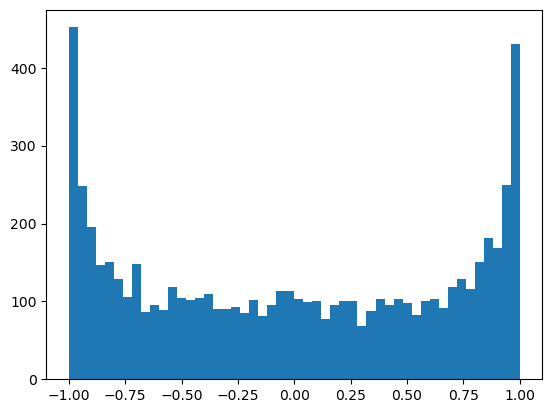

In [120]:
plt.hist(h.view(-1).tolist(), 50);

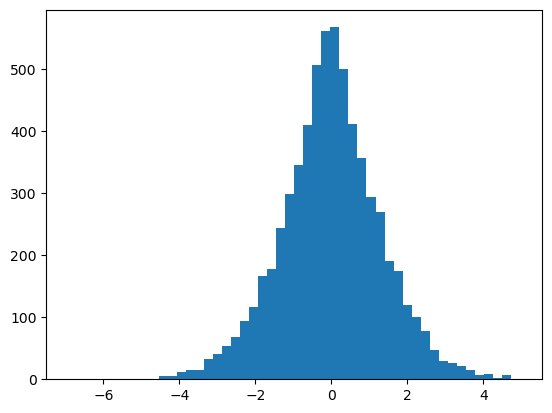

In [121]:
plt.hist(hpreact.view(-1).tolist(), 50);

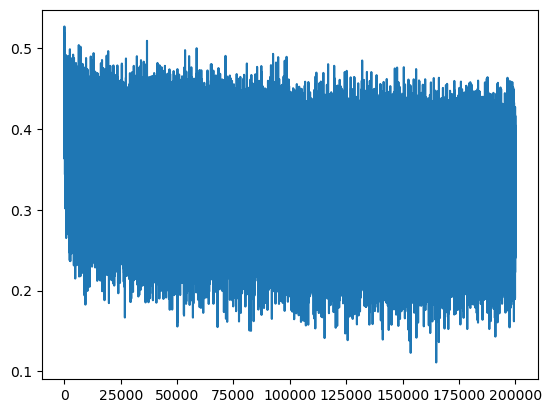

In [122]:
plt.plot(lossi)

In [123]:
# calibrate the batch norm at the end of the training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

In [124]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) # concat into  (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdims = True)) / hpreact.std(0, keepdims = True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss('val')

train 2.0682756900787354
val 2.1081905364990234


In [125]:
# log loss

# original : 
train  2.12453842163038594
val 2.168196439743042

# fix softmax confidently wrong;
train 2.07
val 2.13

# fix tanhlayer too saturated at init;
train 2.0373144149780273
val 2.104902744293213

# using the batch normalization layer
train 2.0668601989746094
val 2.111314535140991

SyntaxError: invalid syntax (3455304067.py, line 4)

In [126]:
# sample from the model 

g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize will all ...
    while True:
        emd = C[torch.tensor([context])] # (1,blocksize, d)
        h = torch.tanh(emd.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1,generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

charlixabbhllvinksmrizhthtlshalasskerrisebrdygn.
fradireegungracestcheigh.
psleggbbh.
mardin.
qustunnslinghtvinniswaverogviarisixfkydinissabrendia.
gabbillinnstef.
phannissandsyadnmmarqozelphojsinconsleyndep.
sadlillygonsstton.
zhubastampllhannsthettin.
squels.
blda.
fferrentlechimbldignyntislahkirlestavingnynakhmbersustimbarveevenny.
quychoprishbytonconceyrbck.
zhinnzss.
shlellinnnyer.
scherpmoysiadhillightonstysdiyghnn.
shannstaditth.
toramirrophi.
awrinn.
khlli.


## Training a deep Neural Network

In [135]:
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1#5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


47024


In [136]:
# train the network 
max_steps = 200000
batch_size = 32
lossi = []
ud = []


for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb]
    x = emb.view(emb.shape[0],-1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # after_debug take out retain graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update the parameters
    lr = 1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
     
        
#     if i > 1000:    
#         break # after debug

      0 /  200000: 3.2827
  10000 /  200000: 2.2200
  20000 /  200000: 2.2374
  30000 /  200000: 2.0656
  40000 /  200000: 1.8099
  50000 /  200000: 2.2567
  60000 /  200000: 1.9916
  70000 /  200000: 2.2703
  80000 /  200000: 1.7681
  90000 /  200000: 2.0483
 100000 /  200000: 2.4823
 110000 /  200000: 1.9704
 120000 /  200000: 2.1249
 130000 /  200000: 2.0504
 140000 /  200000: 2.2272
 150000 /  200000: 2.1714
 160000 /  200000: 1.8044
 170000 /  200000: 1.8163
 180000 /  200000: 2.3058
 190000 /  200000: 1.8503


layer 2 (      Tanh): mean -0.05, std 0.77, saturated: 27.34%
layer 5 (      Tanh): mean -0.03, std 0.79, saturated: 27.38%
layer 8 (      Tanh): mean +0.00, std 0.81, saturated: 28.97%
layer 11 (      Tanh): mean -0.04, std 0.81, saturated: 28.16%
layer 14 (      Tanh): mean -0.02, std 0.82, saturated: 35.84%


Text(0.5, 1.0, 'activation distribution')

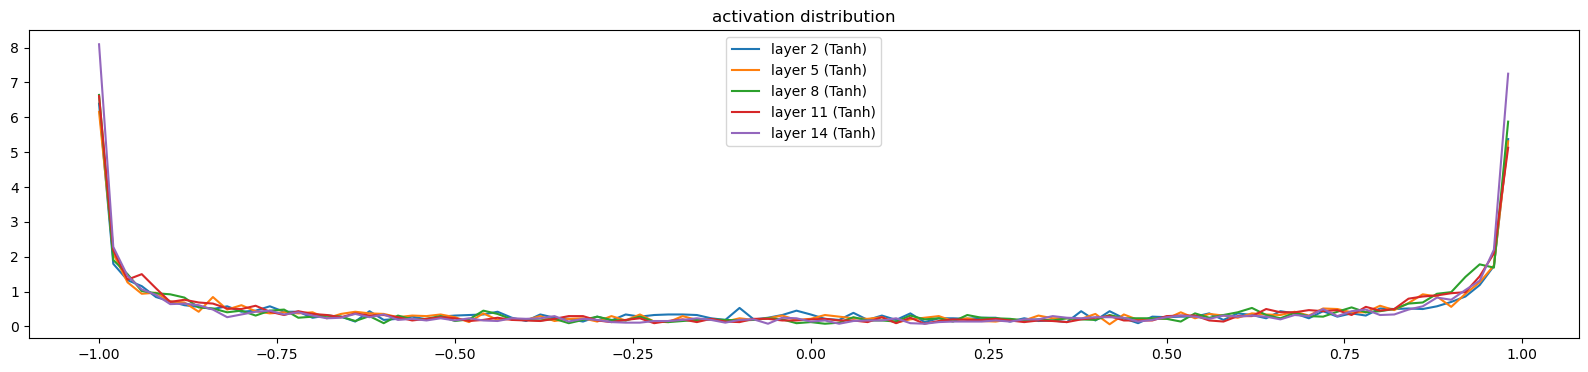

In [137]:
# visualize the histograms
plt.figure(figsize = (20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # excluding the last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')
    
          
          
          

layer 2 (      Tanh): mean +0.000000, std 3.737259e-03,
layer 5 (      Tanh): mean +0.000000, std 3.544861e-03,
layer 8 (      Tanh): mean +0.000000, std 3.186454e-03,
layer 11 (      Tanh): mean -0.000000, std 3.473351e-03,
layer 14 (      Tanh): mean -0.000000, std 3.497389e-03,


Text(0.5, 1.0, 'gradient distribution')

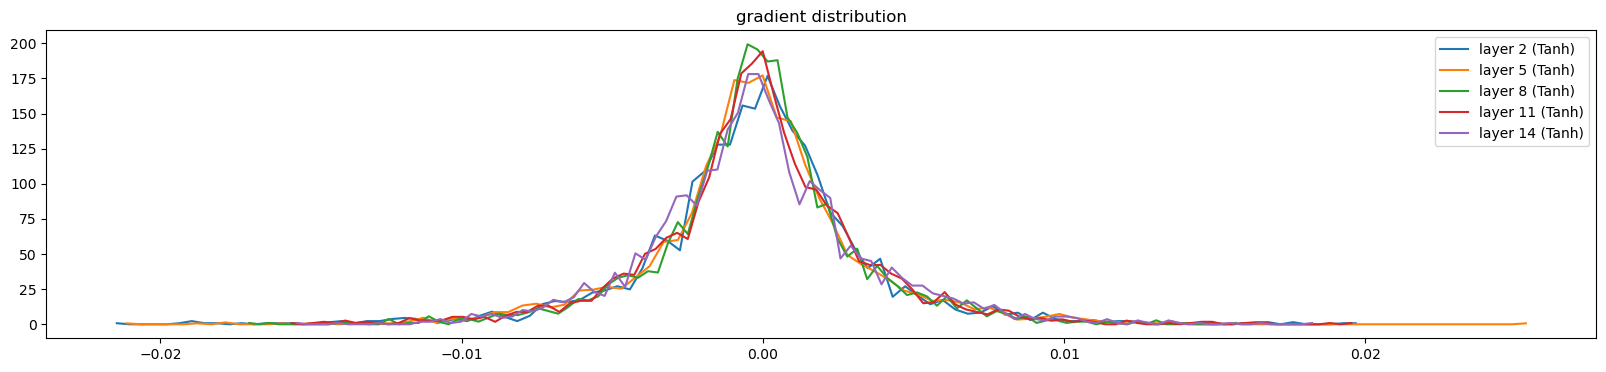

In [138]:
# visualize the histograms
plt.figure(figsize = (20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # excluding the last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e,' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 5.740811e-03 | grad:data ratio 2.217543e-03
weight  (30, 100) | mean +0.000072 | std 2.789742e-03 | grad:data ratio 2.021023e-03
weight (100, 100) | mean +0.000008 | std 1.410969e-03 | grad:data ratio 1.294797e-03
weight (100, 100) | mean -0.000010 | std 1.235654e-03 | grad:data ratio 1.138664e-03
weight (100, 100) | mean +0.000002 | std 1.139473e-03 | grad:data ratio 1.063048e-03
weight (100, 100) | mean -0.000002 | std 1.167294e-03 | grad:data ratio 1.095341e-03
weight  (100, 27) | mean -0.000021 | std 2.199588e-03 | grad:data ratio 1.794921e-03


Text(0.5, 1.0, 'weights gradient distribution')

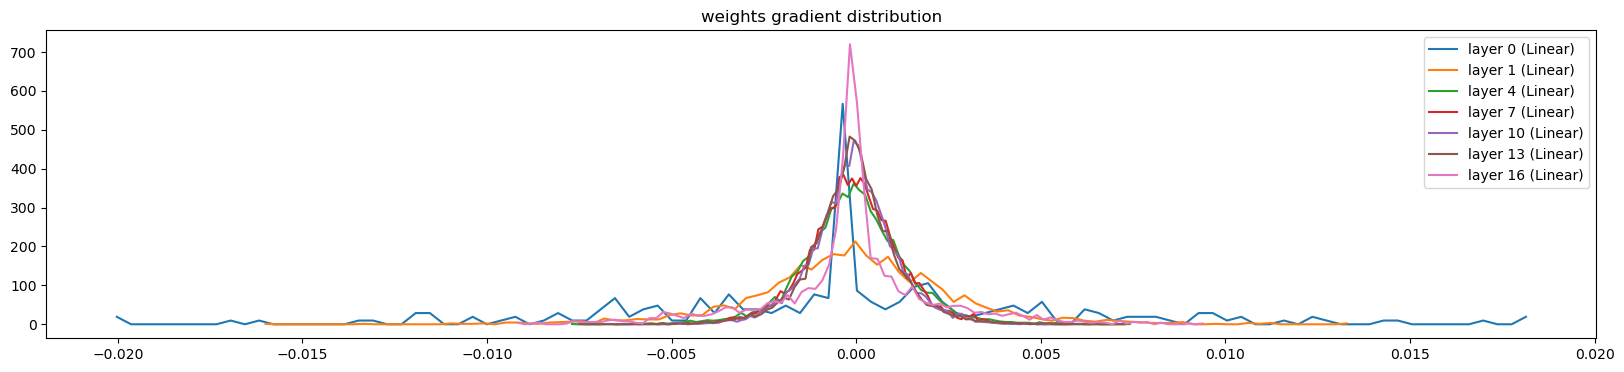

In [139]:
# visualize the histograms
plt.figure(figsize = (20,4))
legends = []
for i ,p in enumerate(parameters): 
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weights gradient distribution')

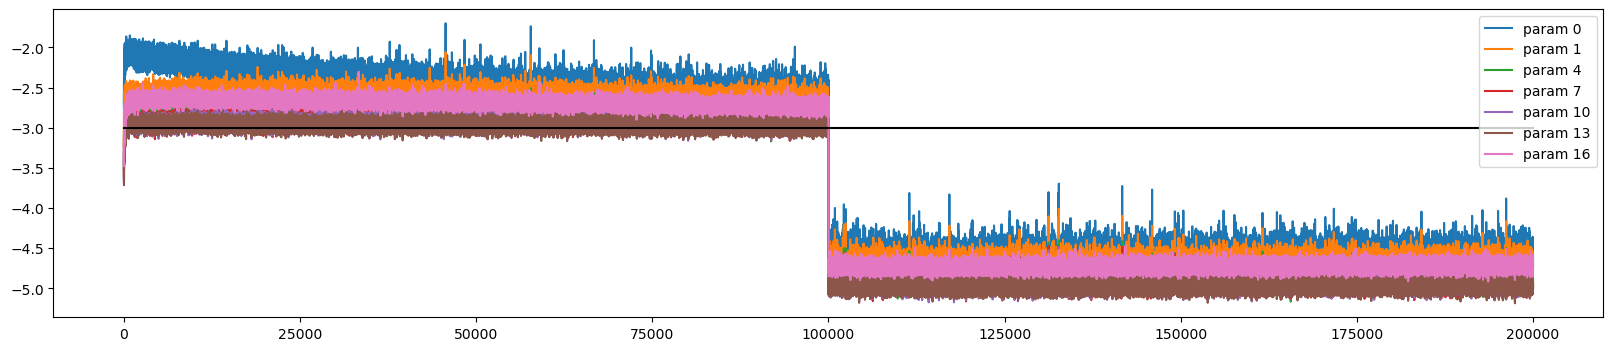

In [140]:
plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim== 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate the plot
plt.legend(legends);

In [141]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.0438709259033203
val 2.0998451709747314


In [142]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khyimrix.
taty.
skanda.
emmahnee.
deliah.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
pora.
quint.
sulio.
alianni.
waterri.
jarixi.
jace.
pinsley.


In [143]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
    g = torch.Generator().manual_seed(2147483647+1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0 # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [144]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [145]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
